In [19]:
%matplotlib inline
import pennylane as qml
import torch
import torch.autograd as autograd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np
from IPython import display

## QCircuit parameter
n_wires = 2
n_layers = 3

## ODE parameter
rho = 13
sigma = 10
beta = 8/3
# Solver settings
t_start = 0.0
t_end   = 0.01
n_steps = 10
# Boundary values
x_0 = 0
y_0 = 1
z_0 = 1.05


@qml.qnode(qml.device("default.qubit", wires=n_wires), diff_method="best")
def circuit(x, weights):
    # Embedding
    for i in range(n_wires):
        qml.RY(2*i*torch.arccos((x-t_end/2)/(t_end)),wires = i)
    # Variational ansatz
    qml.BasicEntanglerLayers(weights=weights, wires=range(n_wires))
    # Cost function
    return qml.expval(qml.sum(*[qml.PauliZ(i) for i in range(n_wires)]))

def my_model(x, weights, biases, scaling):
    vcircuit = torch.vmap(circuit, in_dims=(0,None))
    return [scaling[0] * vcircuit(x, weights[0]) + biases[0],
            scaling[1] * vcircuit(x, weights[1]) + biases[1],
            scaling[2] * vcircuit(x, weights[2]) + biases[2]]

def loss_diff_fnc(x, weights, biases, scaling):
    [x_pred, y_pred, z_pred] = my_model(x, weights, biases, scaling)
    grad_outputs_1 = torch.ones_like(x_pred)
    dx_dt = autograd.grad(x_pred, x, grad_outputs=grad_outputs_1, create_graph=True)[0]
    grad_outputs_2 = torch.ones_like(y_pred)
    dy_dt = autograd.grad(y_pred, x, grad_outputs=grad_outputs_2, create_graph=True)[0]
    grad_outputs_3 = torch.ones_like(z_pred)
    dz_dt = autograd.grad(z_pred, x, grad_outputs=grad_outputs_3, create_graph=True)[0]

    # ODE loss
    res_1 = dx_dt - sigma*(y_pred - x_pred)
    res_2 = dy_dt - x_pred*(rho-z_pred) + y_pred
    res_3 = dz_dt - x_pred*y_pred + beta*z_pred
    loss_pde = torch.mean(res_1**2) + torch.mean(res_2**2) + torch.mean(res_3**2)    
    return loss_pde

def loss_boundary_fnc(x, weights, biases, scaling):
    [x_0_pred, y_0_pred, z_0_pred] = my_model(torch.zeros_like(x), weights, biases, scaling)
    loss_boundary = torch.mean((x_0_pred - x_0)**2) + torch.mean((y_0_pred - y_0)**2) + torch.mean((z_0_pred - z_0)**2)
    return loss_boundary

def loss_fnc(weights:list[torch.Tensor], biases:list[torch.Tensor], scaling:list[torch.Tensor]) ->torch.Tensor:
    x = torch.linspace(t_start,t_end,n_steps, requires_grad=True)

    loss_diff     = loss_diff_fnc(x, weights, biases, scaling)
    loss_boundary = loss_boundary_fnc(x, weights, biases, scaling)

    return 100*loss_boundary + loss_diff

# Solve ODE numerically
def loss_analytical_fnc(x, weights, biases, scaling):
    x = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
    [x_pred, y_pred, z_pred] = my_model(x, weights, biases, scaling)

    dudx = lambda x, u: [sigma*(u[1] - u[0]), u[0]*(rho-u[2]) - u[1], u[0]*u[1] - beta*u[2]]
    # sol_analytical = torch.tensor(solve_ivp(dudx, [t_start,t_end], [x_0,y_0,z_0], t_eval=x.detach()).y, requires_grad=True)
    
    sol_analytical = solve_ivp(dudx, [t_start,t_end], [x_0,y_0,z_0], dense_output=True)
    t = np.linspace(t_start,t_end,n_steps)
    sol_analytical =torch.tensor( sol_analytical.sol(t))

    return torch.mean((x_pred - sol_analytical[0])**2) +torch.mean((y_pred - sol_analytical[1])**2) + torch.mean((z_pred - sol_analytical[2])**2)
    

def optimize(n_iter = 100, verbose=0):
    # Solve ODE numerically
    x = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
    dudx = lambda x, u: [sigma*(u[1] - u[0]), u[0]*(rho-u[2]) - u[1], u[0]*u[1] - beta*u[2]]
    sol_analytical = solve_ivp(dudx, [t_start,t_end], [x_0, y_0, z_0], t_eval=x.detach())

    def update(verbose):
        if verbose == 1:
            print(f"Step: {i}  Loss: {loss}")
        elif verbose == 2:
            pass
            fig = plt.figure()
            fig.set_figheight(5)
            fig.set_figwidth(12)

            # Add energy plot on column 1
            ax1 = fig.add_subplot(121)
            ax1.grid()
            ax1.plot(range(len(loss_history)), loss_history, "black")
            ax1.plot(range(len(loss_diff_history)), loss_diff_history, "g")
            ax1.plot(range(len(loss_boundary_history)), loss_boundary_history, "r")
            ax1.plot(range(len(loss_analytical_history)), loss_analytical_history, "y")
            ax1.legend(["total loss", "diff loss", "boundary loss", "analytical loss"], fontsize=13, loc=1)
            ax1.set_yscale('log')
            ax1.set_xlabel("Optimization step", fontsize=13)
            ax1.set_ylabel("Loss", fontsize=13)

            ax2 = fig.add_subplot(122, projection='3d')
            ax2.plot(sol_analytical.y[0], sol_analytical.y[1], sol_analytical.y[2], "r",lw=1)
            x = torch.linspace(t_start, t_end, n_steps, requires_grad=True)
            [x,y,z] = my_model(x, weights, biases, scaling)
            ax2.plot(x.detach(),y.detach(),z.detach(), "g",lw=1)
            ax2.legend(["analytical", "quantum"], fontsize=13)
            ax2.set_xlabel("x", fontsize=13)
            ax2.set_ylabel("y", fontsize=13)
            ax2.set_zlabel("z", fontsize=13)

            display.clear_output(wait=True)
            plt.show()
            print(f"Step: {i}  Loss: {loss}")
    
    for i in range(1,n_iter+1):
        opt.zero_grad()
        # loss = loss_fnc(weights, biases,scaling)
        loss = loss_analytical_fnc(x,weights, biases,scaling)
        loss.backward()
        opt.step()

        loss_history.append(loss.detach())
        loss_diff_history.append(loss_diff_fnc(x, weights, biases, scaling).detach())
        loss_boundary_history.append(loss_boundary_fnc(x, weights, biases, scaling).detach())
        loss_analytical_history.append(loss_analytical_fnc(x, weights, biases, scaling).detach())

        if i%10 == 0 : update(verbose)

weights = [torch.rand((n_layers, n_wires), requires_grad=True), 
           torch.rand((n_layers, n_wires), requires_grad=True),
           torch.rand((n_layers, n_wires), requires_grad=True)]
biases = [torch.rand(1, requires_grad=True), 
          torch.rand(1, requires_grad=True),
          torch.rand(1, requires_grad=True)]
scaling = [torch.rand(1, requires_grad=True), 
          torch.rand(1, requires_grad=True),
          torch.rand(1, requires_grad=True)]
parameters = weights + biases + scaling

# Create optimizer
opt = torch.optim.Adam(parameters, lr=0.01)
loss_history = []
loss_diff_history = []
loss_boundary_history = []
loss_analytical_history = []

In [20]:
# %timeit -n1 -r1 
opt.param_groups[0]["lr"] = 0.1
optimize(n_iter=1000, verbose=2)
opt.param_groups[0]["lr"] = 0.01
optimize(n_iter=100, verbose=2)


KeyboardInterrupt: 

In [24]:
x = torch.linspace(t_start,t_end,n_steps, requires_grad=True)
[x_pred, y_pred, z_pred] = my_model(x, weights, biases, scaling)

grad_outputs_1 = torch.ones_like(x_pred)
dx_dt = autograd.grad(x_pred, x, grad_outputs=grad_outputs_1, create_graph=True)[0]
grad_outputs_2 = torch.ones_like(y_pred)
dy_dt = autograd.grad(y_pred, x, grad_outputs=grad_outputs_2, create_graph=True)[0]
grad_outputs_3 = torch.ones_like(z_pred)
dz_dt = autograd.grad(z_pred, x, grad_outputs=grad_outputs_3, create_graph=True)[0]

# ODE loss
res_1 = dx_dt - sigma*(y_pred - x_pred)
res_2 = dy_dt - x_pred*(rho-z_pred) + y_pred
res_3 = dz_dt - x_pred*y_pred + beta*z_pred
loss_pde = torch.mean(res_1**2) + torch.mean(res_2**2) + torch.mean(res_3**2)    

In [27]:
torch.mean(res_2**2)

tensor(0.0142, dtype=torch.float64, grad_fn=<MeanBackward0>)

Text(0.5, 0.92, 'Lorenz Attractor')

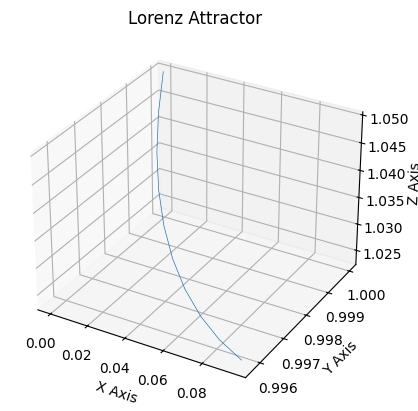

In [28]:
x = torch.linspace(t_start,t_end,n_steps)
dudx = lambda x, u: [sigma*(u[1] - u[0]), u[0]*(rho-u[2]) - u[1], u[0]*u[1] - beta*u[2]]
sol_analytical = solve_ivp(dudx, [t_start,10], [x_0, y_0, z_0], t_eval=x.detach())

ax = plt.figure().add_subplot(projection='3d')

ax.plot(sol_analytical.y[0], sol_analytical.y[1], sol_analytical.y[2], lw=0.5)
ax.set_xlabel("X Axis")
ax.set_ylabel("Y Axis")
ax.set_zlabel("Z Axis")
ax.set_title("Lorenz Attractor")